#### Trump Hate on Twitter

Implement Gaussian process regression discontinuity design for Trump hate data.

Siegel, Alexandra A., et al. "Trumping hate on Twitter? Online hate speech in the 2016 US election campaign and its aftermath." Quarterly Journal of Political Science 16.1 (2021): 71-104.



In [1]:
# load gpytoch and other packages
import torch
import numpy as np
import pandas as pd
import gpytorch
from scipy.stats import norm
from matplotlib import pyplot as plt
from gpytorch.means import LinearMean, ZeroMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, CosineKernel
from datetime import datetime

torch.manual_seed(12345)

load daily proportion of white nationalist on randomly sampled tweets between June 2015 to June 2017

In [2]:
# read data
data = pd.read_csv("./data/white_nationalist_random.csv")

# format date as datatime
# and turn date into time index
xs = data.date
xs = xs.apply(lambda x: (datetime.strptime(x,"%Y-%m-%d")-datetime.strptime(xs[0],"%Y-%m-%d")).days)
ys_scale = 1e6
ys = torch.tensor(data.norm_hate.values).double() * ys_scale

# xs: time, election indicator, time * election indicator
xs = torch.tensor(np.array([xs.values, data.election.values,
                            xs.values*data.election.values]).T).double()
# xs = xs[:,0:2]
election_day_index = np.where(xs[:,1])[0][0]


we build a Gaussian process regression model with an automatic relevance determination RBF kernel:
$$
f(t,D) \sim\mathcal{GP}(\beta_0+\beta_1 t + \beta_2 D + \beta_3 Dt,K)
$$
The mean function includes a baseline intercept $\beta_0$, a pre-election linear time effect $\beta_1$, an instanteneous change at election $\beta_2$ and a post-election linear time effect $\beta_3+\beta_1$. The covariance function allows non-linear deviation of the daily proportions from the linear trend.

In [3]:
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        # constant country-level mean
        self.mean_module = LinearMean(input_size=train_x.shape[1], bias=True)
        self.covar_module = ScaleKernel(RBFKernel(active_dims=[0]))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

In [4]:
import statsmodels.formula.api as sm

data["time_index"] = xs[:,0].numpy()
lm = sm.ols('norm_hate ~ time_index + election + time_index:election - 1', data).fit()
coefs = lm.params.to_dict()
covariate_names = ["time_index" ,"election" , "time_index:election"]
x_weights = list(map(coefs.get, covariate_names))
print(lm.bic)

-17055.209611175127


now we initialize the model and use `Adam()` optimizer to learn the hyperparameters.

In [5]:
torch.set_default_dtype(torch.float64)
torch.manual_seed(12345)

likelihood = GaussianLikelihood()
model = GPModel(xs, ys, likelihood).double()

# initialize model parameters
hypers = {
    'mean_module.weights': torch.tensor([0,0,0]), #
    'covar_module.outputscale': 1,
    'covar_module.base_kernel.lengthscale': torch.tensor([90.]), # 90.,10, 90
    'likelihood.noise': 1,
}    

model = model.initialize(**hypers)

# train model
model.train()
likelihood.train()

all_params = set(model.parameters())
model.covar_module.base_kernel.raw_lengthscale.requires_grad = False
optimizer = torch.optim.Adam(all_params, lr=0.05)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 500
losses = []
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(xs)
    loss = -mll(output, ys)
    loss.backward()
    if i % 50 == 0:
        print('Iter %d/%d - Loss: %.3f '  % (
            i , training_iter, loss.item()
        ))
    losses.append(loss.item())
    optimizer.step()


Iter 0/500 - Loss: 2.873 


/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:136: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2189.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 50/500 - Loss: 2.233 
Iter 100/500 - Loss: 2.146 
Iter 150/500 - Loss: 2.123 
Iter 200/500 - Loss: 2.114 
Iter 250/500 - Loss: 2.109 
Iter 300/500 - Loss: 2.107 
Iter 350/500 - Loss: 2.105 
Iter 400/500 - Loss: 2.104 
Iter 450/500 - Loss: 2.104 


visualize the posterior

In [6]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out = model(xs)
    loss = -mll(output, ys)-np.log(ys_scale)
    mu_f = out.mean.numpy()
    lower, upper = out.confidence_region()

# store results
results = pd.DataFrame({"gpr_mean":mu_f/ys_scale})
results['true_y'] = ys/ys_scale
results['gpr_lwr'] = lower/ys_scale
results['gpr_upr'] = upper/ys_scale
results['day'] = xs[:,0].numpy().astype(int)
results.to_csv("./results/TrumpHate_fitted_gpr.csv",index=False) #save to file


/Users/yahoo/anaconda3/lib/python3.7/site-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


In [7]:
# copy training tesnor to test tensors and set election to 1 and 0
test_x1 = xs.clone().detach().requires_grad_(False)
test_x1[:,1] = 1
test_x0 = xs.clone().detach().requires_grad_(False)
test_x0[:,1] = 0

# in eval mode the forward() function returns posterioir
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    out1 = model(test_x1)
    out0 = model(test_x0)

# compute ATE and its uncertainty
effect = out1.mean.numpy()[election_day_index+1]-out0.mean.numpy()[election_day_index-1]
effect_std = np.sqrt((out1.variance.detach().numpy()[election_day_index+1]\
                      +out0.variance.detach().numpy()[election_day_index-1]))
print("instaneous shift on Election Day: {:.2E} +- {:.2E}\n".format(effect/ys_scale, effect_std/ys_scale))
BIC = (3+2+2)*torch.log(torch.tensor(xs.size(0))) + 2*loss*xs.size()[0]
print(norm.cdf(-np.abs(effect/effect_std)))
print("log lik: {:4.4f} \n".format(-loss.numpy()*xs.size(0)))
print("BIC: {:0.3f} \n".format(BIC))

instaneous shift on Election Day: 7.35E-07 +- 2.79E-07

0.0042473333604365615
log lik: 8549.6996 

BIC: -17053.248 



In [8]:
# set model and likelihood to evaluation mode
model.eval()
likelihood.eval()

xss = xs.clone().detach().requires_grad_(False)
xss[xs[:,1]==1,1] = 0
xss[xs[:,1]==1,2] = 0
with torch.no_grad():
    out0 = model(xss)
    mu_f0 = out0.mean.numpy()
    lower0, upper0 = out0.confidence_region()

# compute ATE and its uncertainty
mask1 = (xs[:,0] >= election_day_index ) & (xs[:,1]==1)
effect = out1.mean.numpy()[mask1].mean()-out0.mean.numpy()[mask1].mean()
effect_std = np.sqrt((out1.variance.detach().numpy()[mask1].mean()\
                      + out0.variance.detach().numpy()[mask1].mean()))

print("ATT: {:.2E} +- {:.2E}\n".format(effect/ys_scale, effect_std/ys_scale))

ATT: 8.78E-07 +- 3.04E-07



posterior of instaneous change on Election Day

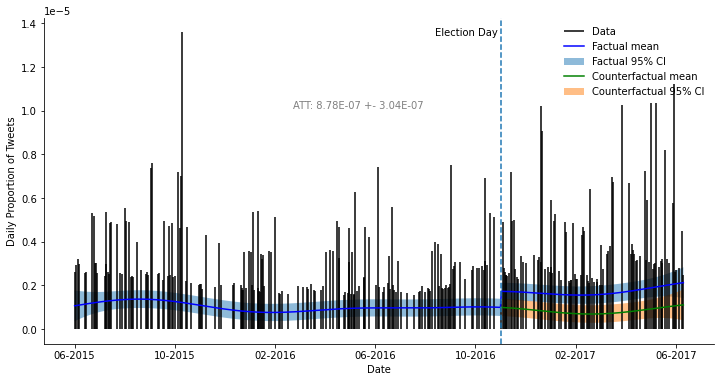

In [9]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.vlines(xs[:,0].numpy(), 0*ys.numpy(), ys.numpy()/ys_scale, color='k')
ax.plot(xs[:,0].numpy(), out.mean.numpy()/ys_scale, 'b')
ax.fill_between(xs[:,0].numpy(), lower.numpy()/ys_scale, upper.numpy()/ys_scale, alpha=0.5)

ax.plot(xs[:,0].numpy()[xs[:,1]==1], out0.mean.numpy()[xs[:,1]==1]/ys_scale, 'g')
ax.fill_between(xs[:,0].numpy()[xs[:,1]==1], lower0.numpy()[xs[:,1]==1]/ys_scale, \
                upper0.numpy()[xs[:,1]==1]/ys_scale, alpha=0.5)


ax.axvline(x=election_day_index, ls="--")
ax.text(election_day_index-80, ys.numpy().max()/ys_scale, "Election Day", rotation=0, verticalalignment='center')
ax.text(election_day_index-250, ys.numpy().max()/ys_scale - 3.6 / ys_scale, "ATT: {:.2E} +- {:.2E}\n".format(effect/ys_scale, effect_std/ys_scale), \
        rotation=0, verticalalignment='center', color='gray')

ax.legend(['Data', 'Factual mean', 'Factual 95% CI', 'Counterfactual mean',\
            'Counterfactual 95% CI'], loc='best', frameon=False)
ax.set_xlabel("Date")
ax.set_ylabel("Daily Proportion of Tweets")
ax.set_xticks(np.arange(xs[:,0].min().data,xs[:,0].max().data,120))
ax.set_xticklabels(["06-2015","10-2015","02-2016","06-2016","10-2016","02-2017","06-2017"])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig("./results/trumphate_est.pdf", dpi=100)